In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("error", category=RuntimeWarning)

from aeons.toy_samples import gaussian_samples, correlated_gaussian_samples, wedding_cake_samples
from aeons.lm_partial import analytic_lm_params, X_end_formula
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, full
from aeons.models import LS, CG
from aeons.endpoint import EndModel

from aeons.tools import pickle_dump, pickle_in

In [2]:
format = {
    # Use LaTeX to write all text
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    # Use 11pt font in plots, to match 11pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    'axes.linewidth': 0.5,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'patch.linewidth': 0.5,
    'legend.frameon': False
}
plt.rcParams.update(format)

#### Figure showing validity of Laplace approximation

In [3]:
from aeons.toy_samples import gaussian_samples, correlated_gaussian_samples
nlive = 500
d, sigma = 10, 0.01
samples = gaussian_samples(nlive, d, sigma)
model = EndModel(samples)

In [4]:
ndead = 16000
logL, nk, _ = model.data(ndead)
X_mean = X_mu(nk)

In [5]:
logLdata = logL[ndead:]
Xdata = X_mean[ndead:]
ls = LS(logLdata, full, Xdata)
theta_l = analytic_lm_params(logLdata, Xdata, 1)

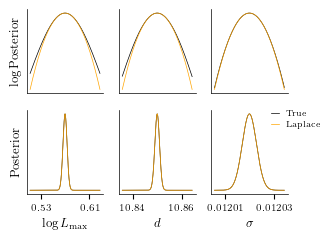

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(3.37, 2.4))
lims = [0.1, 0.001, 0.001]
xlabels = ['$\log L_\mathrm{max}$', '$d$', '$\sigma$']
for i, ax in enumerate(axs[0,:]):
    ax1 = axs[1, i]
    param_max = theta_l[i]
    logprs, logprs_laplace, params = ls.plot_hess(theta_l, i, lims[i], plot=False)
    ax.plot(params, logprs, lw=0.5, color='black', label='True')
    ax.plot(params, logprs_laplace, lw=0.5, color='orange', label='Laplace')
    ax1.plot(params, np.exp(logprs-logprs.max()), lw=0.5, color='black', label='True')
    ax1.plot(params, np.exp(logprs_laplace-logprs_laplace.max()), lw=0.5, color='orange', label='Laplace')
    ax.set_xticks([])
    ax.set_yticks([])
    ax1.set_xlabel(xlabels[i])
    ax1.set_yticks([])
    xlow, xhigh = param_max*(1- 0.7*lims[i]), param_max*(1 + 0.7*lims[i])
    if i == 2:
        ax1.set_xticks([xlow, xhigh], [f'{xlow:.5f}', f'{xhigh:.5f}'] )
    else:
        ax1.set_xticks([xlow, xhigh], [f'{xlow:.2f}', f'{xhigh:.2f}'] )
axs[0][0].set_ylabel(f'$\log \\mathrm{{Posterior}}$', x=0);
axs[1][0].set_ylabel(f'$\mathrm{{Posterior}}$', x=0.05, size=9);
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', handlelength=1, fontsize=6);
plt.savefig('../../../report/figures/laplace_valid.pgf', format='pgf', bbox_inches='tight')

### Bandwidth fits (single iteration)

#### Gaussian

In [2]:
nlive = 500
d, sigma = 30, 0.01
samples = gaussian_samples(nlive, d, sigma)
model = EndModel(samples)

In [3]:
model.logXf_true(100, 0.3)

-101.12291076324709

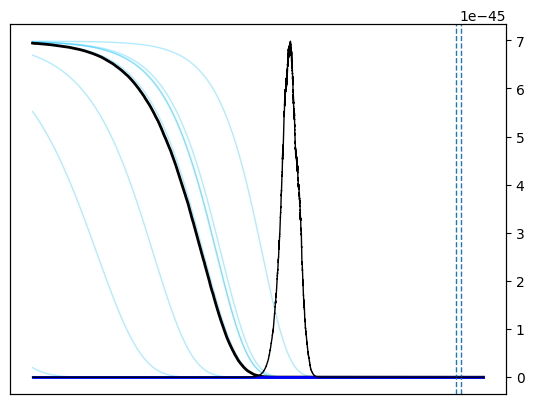

In [20]:
logXarray = np.flip(np.linspace(model.logX_mean[-1], 0, 1000))
Xarray = np.exp(logXarray)

ndead = 5000
logL, nk, logZdead = model.data(ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
theta = model.minimise(ndead, Nset=25)

fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax2.plot(model.logX_mean, np.exp(model.logL) * np.exp(model.logX_mean), lw=1, color='black')
logLmaxm, dm, sigmam = np.median(theta, axis=0)
intercept = 0
for t in theta:
    logLmax, d, sigma = t
    ax1.plot(logXarray, np.exp(full.func(Xarray, [intercept, d, sigma])), lw=1, color='deepskyblue', alpha=0.3)

ax1.plot(model.logX_mean, np.exp(model.logL), lw=2, color='black')
ax1.plot(logXarray, np.exp(full.func(Xarray, [intercept, dm, sigmam])), lw=2, color='blue', alpha=1)
ax1.axvline(x=np.percentile(logX_mean[ndead:-1], 10), lw=1, ls='--')
ax1.axvline(x=np.percentile(logX_mean[ndead:-1], 90), lw=1, ls='--')
ax1.set_ylim(-0.05, 1.05);
ax1.set_xticks([]);
ax1.set_yticks([]);

In [21]:
pickle_dump(f'bandwidth_gauss_fits/gauss_basic{ndead}.pickle', theta)

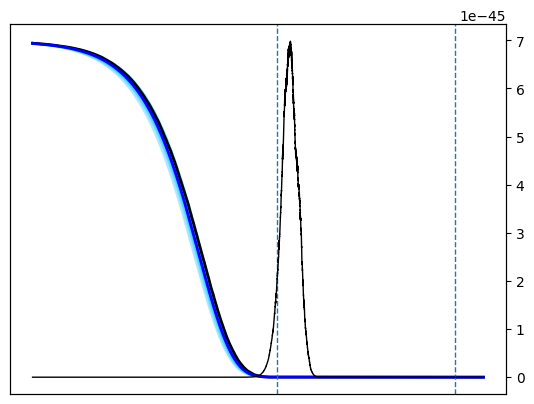

In [34]:
logXarray = np.flip(np.linspace(model.logX_mean[-1], 0, 1000))
Xarray = np.exp(logXarray)

ndead = 50000
logL, nk, logZdead = model.data(ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
alphas = np.arange(0, 1.05, 0.05)
theta, alpha = model.minimise_bandwidth(ndead, alphas, Nset=25, give_alpha=True)
startf = int(ndead*(1-alpha))

fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax2.plot(model.logX_mean, np.exp(model.logL) * np.exp(model.logX_mean), lw=1, color='black')
logLmaxm, dm, sigmam = np.median(theta, axis=0)
intercept = 0
for t in theta:
    logLmax, d, sigma = t
    ax1.plot(logXarray, np.exp(full.func(Xarray, [intercept, d, sigma])), lw=1, color='deepskyblue', alpha=0.3)

ax1.plot(model.logX_mean, np.exp(model.logL), lw=2, color='black')
ax1.plot(logXarray, np.exp(full.func(Xarray, [intercept, dm, sigmam])), lw=2, color='blue', alpha=1)
ax1.axvline(x=np.percentile(logX_mean[startf:-1], 8), lw=1, ls='--')
ax1.axvline(x=np.percentile(logX_mean[startf:-1], 92), lw=1, ls='--')
ax1.set_ylim(-0.05, 1.05);
ax1.set_xticks([]);
ax1.set_yticks([]);

In [35]:
alpha

0.9500000000000001

In [36]:
pickle_dump(f'bandwidth_gauss_fits/gauss{ndead}.pickle', [theta, alpha])

In [23]:
pickle_dump('bandwidth_gauss_fits/gauss_samples.pickle', samples)

#### Wedding

In [39]:
nlive = 500
d, sigma = 20, 0.001
# samples = wedding_cake_samples(nlive, d, sigma)
samples = pickle_in('bandwidth_wedding_fits/wedding_samples.pickle')
model = EndModel(samples)

In [25]:
model.logXf_true(100, 0.3)

-101.12291076324709

##### Showing likelihood projections

In [64]:
logXarray = np.flip(np.linspace(model.logX_mean[-1], 0, 1000))
Xarray = np.exp(logXarray)

ndead = 4000
logL, nk, logZdead = model.data(ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
alphas = np.arange(0, 1.05, 0.05)
theta, alpha = model.minimise_bandwidth(ndead, alphas, Nset=25, give_alpha=True)
startf = int(ndead*(1-alpha))

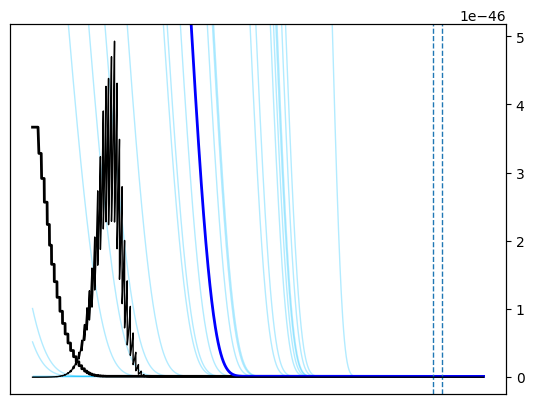

In [69]:
fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax2.plot(model.logX_mean, np.exp(model.logL) * np.exp(model.logX_mean), lw=1, color='black')
logLmaxm, dm, sigmam = np.median(theta, axis=0)
intercept = 0
for t in theta:
    logLmax, d, sigma = t
    ax1.plot(logXarray, np.exp(full.func(Xarray, [intercept, d, sigma])), lw=1, color='deepskyblue', alpha=0.3)

ax1.plot(model.logX_mean, np.exp(model.logL), lw=2, color='black')
ax1.plot(logXarray, np.exp(full.func(Xarray, [intercept, dm, sigmam])), lw=2, color='blue', alpha=1)
ax1.axvline(x=np.percentile(logX_mean[startf:-1], 10), lw=1, ls='--')
ax1.axvline(x=np.percentile(logX_mean[startf:-1], 90), lw=1, ls='--')
ax1.set_ylim(-0.015, 0.3);
ax1.set_xticks([]);
ax1.set_yticks([]);

In [70]:
alpha

0.05

In [71]:
pickle_dump(f'bandwidth_wedding_fits/wedding{ndead}.pickle', [theta, alpha])

In [51]:
pickle_dump('bandwidth_wedding_fits/wedding_samples.pickle', samples)

In [35]:
theta, alpha = pickle_in('bandwidth_wedding_fits/wedding16000.pickle')

In [38]:
pickle_in('bandwidth_wedding_fits/wedding_samples.pickle')

,,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,logL,logL_birth,nlive
,weights,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.359508,0.437032,0.697631,0.060225,0.666767,0.670638,0.210383,0.128926,0.315428,0.363711,...,0.102045,0.208877,0.161310,0.653108,0.253292,0.466311,0.244426,-125000.000000,-inf,500
1,0.000000,0.167626,0.581368,0.377877,0.639652,0.776154,0.084703,0.382479,0.977775,0.002310,0.458911,...,0.776031,0.002200,0.490750,0.319320,0.808156,0.402947,0.069878,-125000.000000,-inf,499
2,0.000000,0.708387,0.013223,0.334417,0.498330,0.741742,0.313064,0.104097,0.825257,0.009823,0.873131,...,0.148343,0.794779,0.810981,0.169468,0.112518,0.572481,0.699707,-125000.000000,-inf,498
3,0.000000,0.559040,0.027690,0.766088,0.714190,0.717260,0.207213,0.070283,0.997284,0.477797,0.726243,...,0.122858,0.351608,0.891463,0.690215,0.731671,0.878289,0.310286,-125000.000000,-inf,497
4,0.000000,0.952586,0.173926,0.476438,0.887651,0.709922,0.535382,0.687828,0.437793,0.396806,0.627838,...,0.960693,0.115886,0.989473,0.200302,0.080904,0.656811,0.673487,-125000.000000,-inf,496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39531,0.004341,0.500394,0.499402,0.499818,0.501762,0.499183,0.499066,0.499157,0.499822,0.498834,0.499203,...,0.499228,0.498973,0.500407,0.501132,0.499167,0.498566,0.500145,-1.660443,-2.697398,5
39532,0.004852,0.498249,0.498304,0.499654,0.499437,0.498956,0.498661,0.500070,0.500703,0.499873,0.500102,...,0.501501,0.500579,0.501760,0.501416,0.501121,0.499296,0.498425,-1.549248,-3.098497,4
39533,0.004852,0.498744,0.500955,0.500123,0.499131,0.500367,0.499025,0.500023,0.499379,0.500423,0.500384,...,0.499636,0.500798,0.500725,0.500697,0.499242,0.501702,0.501039,-1.549248,-3.320887,3


##### Showing alpha selection

In [41]:
logXarray = np.flip(np.linspace(model.logX_mean[-1], 0, 1000))
Xarray = np.exp(logXarray)

ndead = 20000
logL, nk, logZdead = model.data(ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
alphas = np.arange(0, 1, 0.1)
theta, alpha = model.minimise_bandwidth(ndead, alphas, Nset=25, give_alpha=True)
startf = int(ndead*(1-alpha))

In [91]:
ndead = 2000
logL, nk, logZdead = model.data(ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
alphas = np.arange(0, 1, 0.05)
logZs = np.zeros_like(alphas)
thetas = []
for i, alpha in enumerate(alphas):
    startf = int(ndead*(1-alpha))
    ls = LS(logL[startf:], full, X_mean[startf:])
    theta = analytic_lm_params(logL[startf:], X_mean[startf:], 1)
    logZ = ls.logZ(theta) - startf * np.log(abs(logL.min()))
    logZs[i] = logZ
    thetas.append(theta)
alpha_best = alphas[np.argmax(logZs)]
theta_best = thetas[np.argmax(logZs)]
theta1 = analytic_lm_params(logL, X_mean, 1)
theta_best, alpha_best

([20523.24162042157, 25.229943395211844, 0.001834042677556257],
 0.9500000000000001)

In [92]:
ndead = 2000
logL, nk, logZdead = model.data(ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
alphas = np.arange(0, 1, 0.05)
logZs = np.zeros_like(alphas)
thetas = []
for i, alpha in enumerate(alphas):
    startf = int(ndead*(1-alpha))
    ls = LS(logL[startf:], full, X_mean[startf:])
    theta = analytic_lm_params(logL[startf:], X_mean[startf:], 1)
    logZ = ls.logZ(theta) - startf * np.log(startf)
    logZs[i] = logZ
    thetas.append(theta)
alpha_best = alphas[np.argmax(logZs)]
theta_best = thetas[np.argmax(logZs)]
theta1 = analytic_lm_params(logL, X_mean, 1)
theta_best, alpha_best

([14625.022963385243, 23.198729391643692, 0.0018542782795912588], 0.05)

In [68]:
theta_best, theta1

([-0.21721115356819531, 19.46094840330544, 0.0017406008753240677],
 [21.64082007754223, 20.06294091265375, 0.001965087477208483])

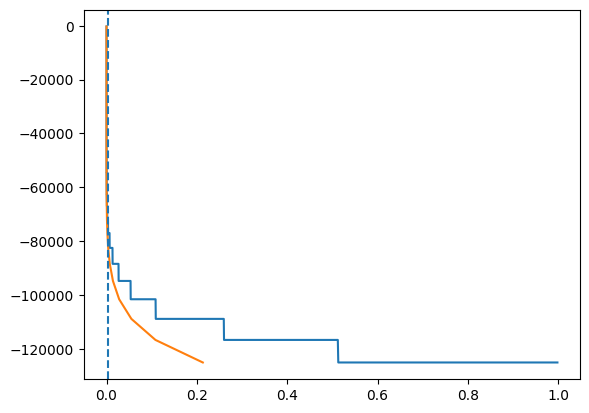

In [64]:
startf_best = int(ndead*(1-alpha_best))
plt.plot(X_mean, logL)
plt.plot(full.inverse(logL, theta_best), logL)
plt.axvline(X_mean[startf], ls='--')

##### Correlated

In [4]:
nlive = 500
d, sigma = 10, 0.1
samples = correlated_gaussian_samples(nlive, d, sigma)
model = EndModel(samples)

In [5]:
ndead = 3000
logL, nk, logZdead = model.data(ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
alphas = np.arange(0, 1, 0.05)
logZs = np.zeros_like(alphas)
thetas = []
for i, alpha in enumerate(alphas):
    startf = int(ndead*(1-alpha))
    ls = LS(logL[startf:], full, X_mean[startf:])
    theta = analytic_lm_params(logL[startf:], X_mean[startf:], 1)
    logZ = ls.logZ(theta) - startf * np.log(abs(logL.min()))
    logZs[i] = logZ
    thetas.append(theta)
alpha_best = alphas[np.argmax(logZs)]
theta_best = thetas[np.argmax(logZs)]
theta1 = analytic_lm_params(logL, X_mean, 1)
theta_best, alpha_best

([-8.04402096571425, 6.299378170205099, 0.08557134968301867],
 0.7000000000000001)

In [6]:
logZs_nop = np.zeros_like(alphas)
thetas_nop = []
for i, alpha in enumerate(alphas):
    startf = int(ndead*(1-alpha))
    ls = LS(logL[startf:], full, X_mean[startf:])
    theta = analytic_lm_params(logL[startf:], X_mean[startf:], 1)
    logZ = ls.logZ(theta)
    logZs_nop[i] = logZ
    thetas.append(theta)
alpha_nop = alphas[np.argmax(logZs_nop)]
theta_nop = thetas[np.argmax(logZs_nop)]

/home/zixiao/Documents/III/project/aeons/aeons/likelihoods.py:109: RuntimeWarning: invalid value encountered in power
  return (2*sigma**2 * (logLmax - logL))**(d/2)


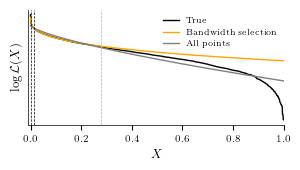

In [7]:
startf_best = int(ndead*(1-alpha_best))
startf_nop = int(ndead*(1-alpha_nop))
plt.figure(figsize=(3.3, 1.5))
plt.plot(X_mean, logL, color='black', lw=1, label='True')
plt.plot(full.inverse(logL, theta_best), logL, color='orange', lw=1, label='Bandwidth selection')
plt.plot(full.inverse(logL, theta1), logL, color='gray', lw=1, label='All points')
plt.axvline(X_mean[startf_best], ls='--', lw=.5, color='orange')
plt.axvline(X_mean[-1], ls='--', lw=.5, color='black')
plt.axvline(X_mean[ndead], ls='--', lw=.5, color='black')
plt.xlim(-0.01, 1)
plt.yticks([])
plt.xlabel('$X$')
plt.ylabel('$\log \mathcal{{L}}(X)$')
plt.legend(frameon=False, loc='upper right', fontsize=6)
plt.savefig('../../../report/figures/box_prior.pgf', format='pgf', bbox_inches='tight')

In [ ]:
startf_best = int(ndead*(1-alpha_best))
plt.plot(logX_mean, np.exp(logL))
plt.plot(full.inverse(logL, theta_best), np.exp(logL))
plt.axvline(logX_mean[startf_best], ls='--')
plt.axvline(logX_mean[ndead], ls='--')
plt.xlim(0, 1)

In [21]:
ndead = 10000
model.minimise(ndead, Nset=10)

[[-0.007937599795213135, 9.928386242099732, 0.08948571474822915],
 [0.7947202828561557, 12.275141027047463, 0.10500907878056573],
 [0.2628852322033146, 11.156106748483602, 0.10154491780639224],
 [0.3344029002375071, 10.866385727585893, 0.09837614408185118],
 [1.2919875574643607, 14.03200536472867, 0.1162692375349896],
 [0.019109253914885382, 9.658757277784165, 0.08694890385983114],
 [0.0356161093263383, 9.888329134742456, 0.08629056925144563],
 [-0.14003591309403074, 9.582737701155922, 0.08633030014261082],
 [1.0838844093419597, 12.062846508542515, 0.10133399926181622],
 [0.023243539919778122, 10.535621938294415, 0.09469245234375044]]

In [22]:
alphas = np.arange(0, 1.05, 0.05)
model.minimise_bandwidth(ndead, alphas, Nset=10, give_alpha=True)

([[-0.7876478405391687, 8.921254702350291, 0.08773693803569416],
  [-0.5242588399391455, 9.39264845690792, 0.08908827903622361],
  [-0.45763838281558833, 9.667437966189327, 0.08937096932049973],
  [-0.20041743191455907, 9.739880574775114, 0.08966452905590269],
  [-0.4278824277753852, 9.58848588063888, 0.09054223426900866],
  [-0.2004362305206282, 9.845459107418458, 0.08996004182976718],
  [-0.3213160719978294, 9.60574104321069, 0.08931265191639753],
  [-0.7113735484515651, 9.426892395947556, 0.08912471738096686],
  [-0.0595428691552673, 9.76006829666476, 0.08938351322001242],
  [-0.5698705690919823, 9.224263767017808, 0.08802629083375808]],
 0.8)

In [19]:
logL, nk, _ = model.data(ndead)
X_mean = X_mu(nk)
theta_best = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
alpha_best = 0
logZi = -np.inf
for alpha in alphas:
    startf = int(ndead * (1 - alpha))
    logLf = logL[startf:]
    X_meanf = X_mean[startf:]
    ls = LS(logLf, full, X_meanf)
    theta = analytic_lm_params(logLf, X_meanf, 1)
    logZf = ls.logZ(theta)# + startf * np.log(startf)
    print(logZf)
    if logZf > logZi:
        logZi = logZf
        theta_best = theta
        alpha_best = alpha
alpha_best

1032.3893317015516
1251.0447333416696
1072.1612094514385
856.0567174268507
895.2619838829576
1037.2839526729413
1143.089984641739
1346.2902930701262
1461.73468631133
1465.0457815746392
1470.552268908509
1079.8694648712944
681.5347887692145
-160.2616224137771
-1242.190650646002
-1941.8420657948932
-2964.273012772486
-4382.300394404573
-6017.507512351951
-8969.95556042644
-14600.291839741485


0.5

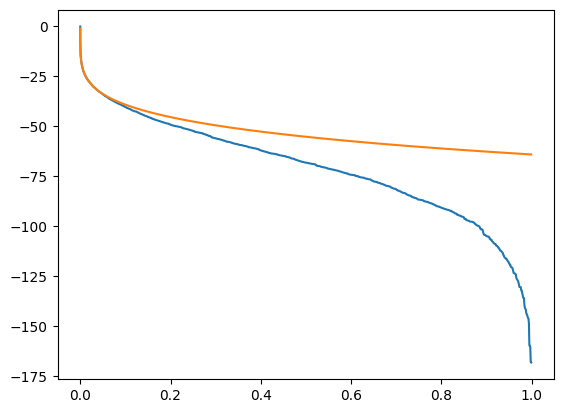

In [20]:
X = np.exp(model.logX_mean)
plt.plot(X, model.logL)
plt.plot(X, full.func(X, theta_best))